As Peter does in his Grid-predict notebook, specify initial parameters from which to work.

In [1]:
%matplotlib inline

import sys
sys.path.append('../..')

from matplotlib import pylab as plt

import itertools
import numpy
import scipy
import scipy.special
import time
import random

from ipywidgets import interact
from IPython.display import display, Markdown, clear_output

from crocodile.synthesis import *
from crocodile.simulate import *
from crocodile.antialias import *
from util.visualize import *
from arl.test_support import create_named_configuration, export_visibility_to_hdf5
from arl.data_models import *

In [4]:
theta = 0.1
lam = 20480
grid_size = int(theta*lam)

Using Sze-Tan's gridder with R=4, x_0=0.25
Mean error: 1.17905513234e-08
Optimal du = 5.0


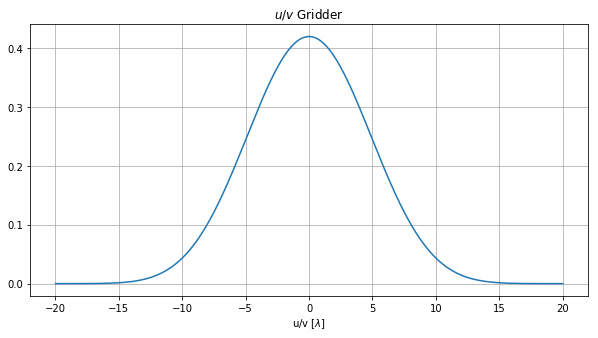

[-0.49995    -0.49985001 -0.49975002 ...,  0.49975002  0.49985001  0.49995   ]
(10001,)


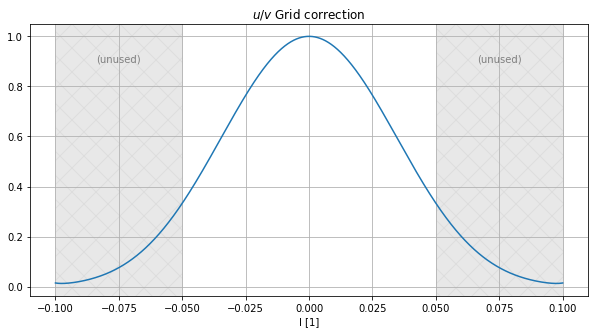

In [6]:
aa_over = 4096
aa_support = 8
aa_x0 = 0.25
aa_mode = 0
aa_szetan = True
if aa_support == 1:
    print("Using trivial gridder")
    aa_gcf = numpy.ones((aa_over, aa_support))
    def aa(x): return numpy.ones_like(x)
elif aa_szetan:
    print("Using Sze-Tan's gridder with R=%d, x_0=%g" % (aa_support//2, aa_x0))
    aa_gcf = sze_tan_gridder(aa_support//2, aa_x0, aa_over)
    def aa(x):
        return sze_tan_grid_correction_gen(aa_support//2, aa_x0, x)
    print("Mean error:", sze_tan_mean_error(aa_support//2, aa_x0))
else:
    aa_parameter = aa_support
    print("Using PSWF with mode %d and parameter %g" % (aa_mode, aa_parameter))
    aa_gcf = kernel_oversample(anti_aliasing_function(grid_size, aa_mode, aa_parameter), aa_over, aa_support)
    aa_gcf /= numpy.sum(aa_gcf[0])
    def aa(x):
        return scipy.special.pro_ang1(aa_mode, aa_mode, aa_parameter, 2*x)[0]
    
# Calculate appropriate step length to give us full accuracy for a field of view of size theta
du = du_opt = aa_x0/(theta/2)
print("Optimal du =", du)

# Plot gridding function
plt.rcParams['figure.figsize'] = 10, 5
r = numpy.arange(-aa_over*(aa_support//2), aa_over*((aa_support+1)//2)) / aa_over
plt.plot(du_opt*r, numpy.transpose(aa_gcf).flatten().real);
plt.xticks(du_opt*numpy.arange(-(aa_support//2), ((aa_support+1)//2)+1))
plt.grid(True);plt.xlabel('u/v [$\lambda$]');plt.title('$u/v$ Gridder');plt.show()

# Plot grid correction function
theta_x0 = theta/aa_x0/2
x = coordinates(10001)
print(x)
sze_aa_im = aa(x)
print(sze_aa_im.shape)
plt.plot(theta*x/aa_x0/2, sze_aa_im)
plt.title('$u/v$ Grid correction');plt.grid(True);plt.xlabel('l [1]')
plt.axvspan(theta/2, theta_x0/2, color='lightgray', hatch='x', alpha=0.5)
plt.axvspan(-theta/2, -theta_x0/2, color='lightgray', hatch='x', alpha=0.5)
plt.annotate('(unused)', xy=((theta+theta_x0)/4,0.9), ha='center', color='gray')
plt.annotate('(unused)', xy=(-(theta+theta_x0)/4,0.9), ha='center', color='gray');

Using Sze-Tan's gridder with R=2, x_0=0.125
Mean error: 7.1257870709e-06
max_n = 0.002503132837
Optimal dw = 49.9374216791


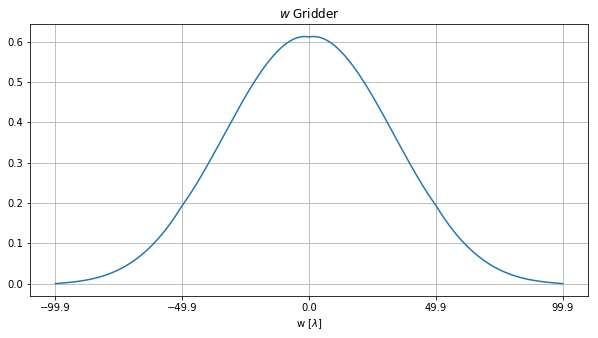

[-0.49995    -0.49985001 -0.49975002 ...,  0.49975002  0.49985001  0.49995   ]
[ 0.23630141  0.23607546  0.23585053 ...,  0.23585053  0.23607546
  0.23630141]


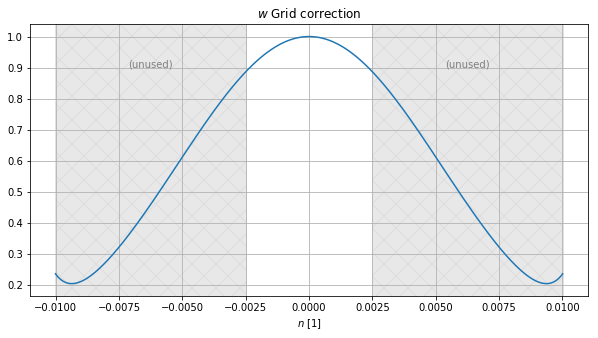

In [7]:
aa_support_w = 4
aa_x0_w = 0.125
aa_parameter_w = aa_support_w
aa_szetan_w = True
if aa_support_w == 1:
    print("Using trivial gridder")
    aa_gcf_w = numpy.ones((aa_over, aa_support_w))
    def aa_w(x): return numpy.ones_like(x)
elif aa_szetan_w:
    print("Using Sze-Tan's gridder with R=%d, x_0=%g" % (aa_support_w//2, aa_x0_w))
    aa_gcf_w = sze_tan_gridder(aa_support_w//2, aa_x0_w, aa_over)
    def aa_w(x):
        return sze_tan_grid_correction_gen(aa_support_w//2, aa_x0_w, x)
    print("Mean error:", sze_tan_mean_error(aa_support_w//2, aa_x0_w))
else:
    aa_gcf_w = kernel_oversample(anti_aliasing_function(grid_size, 0, aa_parameter_w), aa_over, aa_support_w)
    aa_gcf_w /= numpy.sum(aa_gcf_w[0])
    def aa_w(x):
        return scipy.special.pro_ang1(aa_mode, aa_mode, aa_parameter_w, 2*x)[0]

# Calculate appropriate step length to give us full accuracy for a field of view of size theta
max_n = 1.0 - numpy.sqrt(1.0 - 2*(theta/2)**2)
print("max_n =", max_n)
dw = dw_opt = aa_x0_w / max_n
print("Optimal dw =", dw)

# Plot gridding function
plt.rcParams['figure.figsize'] = 10, 5
r = numpy.arange(-aa_over*(aa_support_w//2), aa_over*((aa_support_w+1)//2)) / aa_over
plt.plot(dw_opt*r, numpy.transpose(aa_gcf_w).flatten().real);
plt.xticks(dw_opt*numpy.arange(-(aa_support_w//2), ((aa_support_w+1)//2)+1))
plt.grid(True); plt.xlabel('w [$\lambda$]'); plt.title('$w$ Gridder'); plt.show()

x = coordinates(10001)
print(x)
sze_w_im = aa_w(x)
print(sze_w_im)
plt.plot(max_n*x/aa_x0_w, sze_w_im);
plt.title('$w$ Grid correction'); plt.grid(True); plt.xlabel('$n$ [1]');
max_n_x0 = max_n/aa_x0_w/2
plt.axvspan(max_n, max_n_x0, color='lightgray', hatch='x', alpha=0.5)
plt.axvspan(-max_n, -max_n_x0, color='lightgray', hatch='x', alpha=0.5)
plt.annotate('(unused)', xy=((max_n+max_n_x0)/2,0.9), ha='center', color='gray')
plt.annotate('(unused)', xy=(-(max_n+max_n_x0)/2,0.9), ha='center', color='gray');

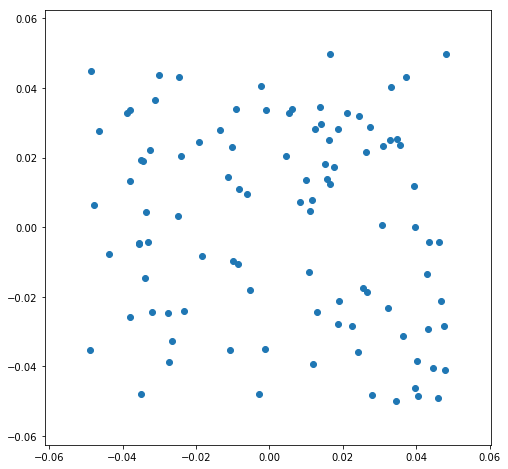

In [8]:
Npt = 100
points = theta * (numpy.random.rand(Npt,2)-0.5)
#points = numpy.array([[0,0]])
plt.rcParams['figure.figsize'] = 8, 8
plt.scatter(points[:,0], points[:,1]);

These are exact copies of peters functions in grid-predict. Used to compare with sze-tan w-stacking.

In [9]:
def predict(dist_uvw, du=du_opt, dw=dw_opt, apply_aa = False, apply_aa_w = False):
    # Get image coordinates
    ls, ms = numpy.transpose(points)
    ns = numpy.sqrt(1.0 - ls**2 - ms**2) - 1
    # Evaluate grid correction functions in uv & w
    aas = numpy.ones(len(ls))
    if apply_aa:
         aas *= aa(du*ls) * aa(du*ms)
    if apply_aa_w:
        aas *= aa_w(dw*ns)
        # Now simulate points, dividing out grid correction
    vis = 0
    for l,m, a in zip(ls, ms, aas):
        vis += simulate_point(dist_uvw, l, m) / a
    return vis

def predict_grid(u,v,w,ov_u,ov_v,ov_w,du=du_opt, dw=dw_opt, visualise=False):
    
    # Generate offsets that we are going to sample at
    ius, ivs, iws = numpy.meshgrid(numpy.arange(aa_support), numpy.arange(aa_support), numpy.arange(aa_support_w))
    dus = du*(ius.flatten()-(aa_support//2)+ov_u/aa_over)
    dvs = du*(ivs.flatten()-(aa_support//2)+ov_v/aa_over)
    dws = dw*(iws.flatten()-(aa_support_w//2)+ov_w/aa_over)
    
    # Get grid convolution function for offsets
    aas = aa_gcf[ov_u,ius.flatten()] * aa_gcf[ov_v,ivs.flatten()] * aa_gcf_w[ov_w,iws.flatten()]

    # Add offsets to all uvw coordinates
    us = numpy.array(u)[:,numpy.newaxis] + dus[numpy.newaxis,:]
    vs = numpy.array(v)[:,numpy.newaxis] + dvs[numpy.newaxis,:]
    ws = numpy.array(w)[:,numpy.newaxis] + dws[numpy.newaxis,:]
    # Visualise sampling pattern?
    if visualise:
        ax = plt.subplot(111, projection='3d')
        ax.scatter(us,vs,ws, color='red');
        
        ax.set_xlabel('u'); ax.set_ylabel('v'); ax.set_zlabel('w')

    # Predict visibilities
    vis = predict(numpy.transpose([us.flatten(),vs.flatten(),ws.flatten()]),
                  du=du, dw=dw, apply_aa=True, apply_aa_w=True).reshape(us.shape)
    
    # Convolve with gridder, sum up
    #print(vis * aas[numpy.newaxis,:])
    #print(aas)
    return numpy.sum(vis * aas[numpy.newaxis,:], axis=1)

5.0
49.9374216791

Direct:  (6.12830976425+12.9640956348j)
Grid:    (6.12820301427+12.9641891475j)
Error:   1.4191611237e-06


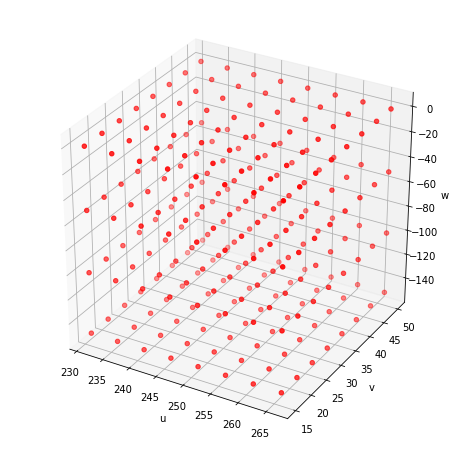

In [10]:
def test(u=0,v=0,w=0, ov_u=0,ov_v=0,ov_w=0, du=du_opt, dw=dw_opt,visualise=True):
    print()
    vis = predict(numpy.transpose([[u],[v],[w]]))
    print("Direct: ", vis[0])
    vis_sum = predict_grid([u],[v],[w],ov_u,ov_v,ov_w,du,dw,visualise=visualise)
    print("Grid:   ", vis_sum[0])
    print("Error:  ", numpy.abs(vis[0]-vis_sum[0]) / Npt)
print(du_opt)
print(dw_opt)    
test(u=250.0,v=35.0,w=-dw_opt+0.0000001, ov_u=1024,ov_v=0,ov_w=0, du=du_opt, dw=dw_opt,visualise=True)

In [11]:
def generate_sky(theta, lam, points,aa=aa,aa_w=aa_w):
    grid_size = int(theta*lam)
    sky = numpy.zeros((grid_size,grid_size),dtype = numpy.complex128)
    
    l = points[0]
    m = points[1]
        
    lc = ((l / theta + 0.5) * grid_size)
    mc = ((m / theta + 0.5) * grid_size)
    
    lc = numpy.floor(lc).astype(int)
    mc = numpy.floor(mc).astype(int)
    
    lq = ((lc - grid_size/2)/grid_size) * theta
    mq = ((mc - grid_size/2)/grid_size) * theta    
    n = numpy.sqrt(1 - lq**2 - mq**2) - 1.0
    gridcor = 1.0 * aa(du*numpy.array(lq)) * aa(du*numpy.array(mq)) * aa_w(dw*numpy.array(n))
    
    for i in numpy.arange(lc.shape[0]):
        sky[lc[i],mc[i]] += (1.0 + 1j*0.0) / gridcor[i] 
        
        
    
        
    plt.scatter(l,m)
    plt.title("Sky Brightness Distribution")
    plt.ylim((-theta/2,theta/2))
    plt.xlim((-theta/2,theta/2))
    plt.show()        
        
    return(sky)

def predict_dft(coords,u=0.0,v=0.0,w=0.0):
    l = coords[0]      
    m = coords[1]  
    n = numpy.sqrt(1 - l**2 - m**2) - 1.0
    vis = numpy.sum((1.0 + 1j*0.0) * numpy.exp (-2j*numpy.pi*(u*l + v*m + w*n)))
    return(vis)


def predict_dft_q(coords,theta,lam,u=0.0,v=0.0,w=0.0):
    grid_size = int(theta*lam)
    vis = 0.0 + 1j*0.0
    
        
    l = coords[0]      
    m = coords[1]        
    # Because of the quantization of the source onto the sky grid,
    # need to work out its effective sky co-ordinate
    lc = numpy.floor((l/theta + 0.5) * grid_size).astype(int)
    mc = numpy.floor((m/theta + 0.5) * grid_size).astype(int)
    lq = ((lc - grid_size/2)/grid_size) * theta
    mq = ((mc - grid_size/2)/grid_size) * theta    
    n = numpy.sqrt(1 - lq**2 - mq**2) - 1.0
    vis = numpy.sum((1.0 + 1j*0.0) * numpy.exp (-2j*numpy.pi*(u*lq + v*mq + w*n)))
            

    return(vis)




In [12]:
print(aa_gcf.shape)

(4096, 8)


Fresnel: 
(1+0j)
Max W: 
144.75513655
W-Planes: 
8.0


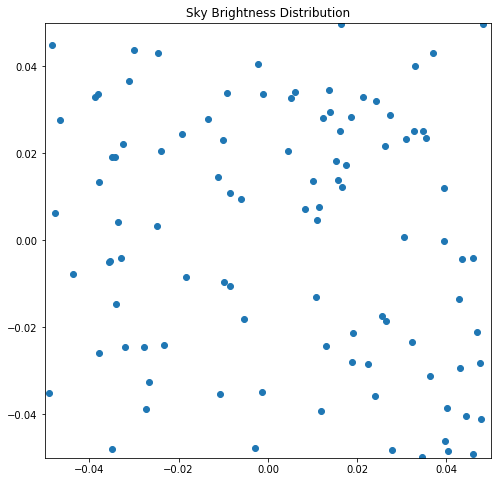

-4.0
Generating Plane  0
Generating Plane  1
Generating Plane  2
Generating Plane  3
Generating Plane  4
Generating Plane  5
Generating Plane  6
Generating Plane  7
##### W-Stacking ######
(-11.6897304755+0.416101388197j)
DFT at u:-250.000000,v:520.000000,w:0.000000
(-11.5889949412+1.0026833635j)
DFT(Q) at u:-250.567627,v:515.786133,w:0.000000
(-11.6900649177+0.416162293759j)
Error between the two:  3.39942801213e-06


In [13]:
#@interact(theta=theta,lam=lam,points=points,x0=aa_x0,u=(-lam/2,lam/2,du),v=(-lam/2,lam/2,du),w=(-lam/2,lam/2,dw),
#          ov_u=(0,aa_over-1), ov_v=(0,aa_over-1), ov_w=(0,aa_over-1))

#X0 is fixed at 0.25 for this!!
def predict_wstack(theta,lam,points,x0,du=du_opt, dw=dw_opt,
                   gcf_support=aa_gcf, gcf_support_w=aa_gcf_w, aa=aa, aa_w=aa_w,
                   u=0.0, v=0.0, w=0.0, ov_u=0, ov_v=0, ov_w=0):
    grid_size = int(theta * lam)
    ls,ms = theta*coordinates2(grid_size)
    ns = numpy.sqrt(1 - ls**2 - ms**2) - 1.0
    
    #Fresnel Pattern
    fresnel_pattern = w_kernel_function(ls, ms, dw)
    print("Fresnel: ")
    print(fresnel_pattern[1024,1024])
    max_w = numpy.sin(theta/2) * numpy.sqrt(grid_size**2 + grid_size**2)
    print("Max W: ")
    print(max_w)
    w_planes = 2*numpy.ceil(max_w/(2*dw)) + aa_support_w
    print("W-Planes: ")
    print(w_planes)
    #points = numpy.asarray([[0.04,-0.03],[-0.04,0.02]]).T
    # Define some point sources on the sky 
    sky = generate_sky(theta,lam,points.T)
    
    stacks = numpy.zeros(shape=(int(w_planes),2*grid_size,2*grid_size),dtype=numpy.complex128)     
    
    print(-w_planes//2)
    sky = sky * (fresnel_pattern ** (-w_planes//2))
    for i in numpy.arange(int(w_planes)):
        print("Generating Plane ",i)
        skyg = numpy.zeros(shape=(2*grid_size,2*grid_size),dtype=numpy.complex128)
        skyg[sky.shape[0]//2:sky.shape[0]//2+sky.shape[0],sky.shape[1]//2:sky.shape[1]//2+sky.shape[1]] = sky
        skyg = numpy.fft.fftshift(skyg)
        stacks[i,:,:] = numpy.fft.fftshift(numpy.fft.fft2(skyg,s=(2*grid_size,2*grid_size)))
        #print(stacks[i,2048,2048])
        sky = sky * fresnel_pattern
        
        
    
    # Now do reverse convolution using Sze Tan Kernels
    ius, ivs, iws = numpy.meshgrid(numpy.arange(aa_support), numpy.arange(aa_support),numpy.arange(aa_support_w))
    dus = du*(ius.flatten()-(aa_support//2)+ov_u/aa_over)
    dvs = du*(ivs.flatten()-(aa_support//2)+ov_v/aa_over)
    dws = dw*(iws.flatten()-(aa_support_w//2)+ov_w/aa_over)

    # Get grid convolution function for offsets
    aas = aa_gcf[ov_u,ius.flatten()] * aa_gcf[ov_v,ivs.flatten()] * aa_gcf_w[ov_w,iws.flatten()]

    # Add offsets to all uvw coordinates
    us = numpy.array([u])[:,numpy.newaxis] + dus[numpy.newaxis,:]
    vs = numpy.array([v])[:,numpy.newaxis] + dvs[numpy.newaxis,:]
    ws = numpy.array([w])[:,numpy.newaxis] + dws[numpy.newaxis,:] 
    
    # Work out Planes
    wsp = (ws//dw + w_planes//2).astype(int)
    usp = (us//du + grid_size).astype(int)
    vsp = (vs//du + grid_size).astype(int)
    #print(usp)
    print("##### W-Stacking ######")
    vis_wstack = numpy.sum(stacks[wsp[0],usp[0],vsp[0]]*aas) * numpy.exp(2j*numpy.pi * 0)
    print(vis_wstack)
    
    
    # Work out correct u/v/w from oversampling values
    
    ovuu = du*(ov_u/aa_over)
    ovvv = du*(ov_v/aa_over)
    ovww = dw*(ov_w/aa_over)
    
    uss = u - ovuu # My sign convention is the wrong way around (woops)
    vss = v - ovvv
    wss = w - ovww
    
    visd=predict_dft(points.T,u=uss,v=vss,w=wss)
    print("DFT at u:%f,v:%f,w:%f"%(u,v,w))
    print(visd)
    vis=predict_dft_q(points.T,theta,lam,u=uss,v=vss,w=wss)
    
    print("DFT(Q) at u:%f,v:%f,w:%f"%(uss,vss,wss))
    print(vis)

    print("Error between the two: ",abs(vis_wstack-vis)/Npt)

    return(vis_wstack)
    
visws = predict_wstack(theta,lam,points,aa_x0,u=-250.0,v=520.0,w=0,ov_u=465,ov_v=3452,ov_w=0)

In [14]:
viswss = visws
print(viswss * 1.05 * numpy.exp(2j * numpy.pi * -0.028))

(-12.0082875871+2.57843352142j)


In [19]:
import astropy
import astropy.units as uv
import itertools

import h5py


def export_gcf_to_hdf5(aa_gcf,filename='sepkern.hdf5'):
    output = h5py.File(filename, "a")
    output.attrs[u'x0'] = aa_x0
    output.attrs[u'du'] = du
    output.attrs[u'dw'] = dw
    sepkern_name = "sepkern/kern"
    size = aa_gcf.shape[0]
    oversampling = aa_gcf.shape[1]
    #print(aa_gcf.shape)
    #aa_gcf = numpy.transpose(aa_gcf).flatten()
    #print(aa_gcf.shape)
    #aa_gcf = aa_gcf.reshape((oversampling,size))
    #print(aa_gcf.shape)
    output[sepkern_name] = aa_gcf
    output.flush()
    output.close()
    
def export_aa_to_hdf5(aa_gcf,filename='sepkern_sze.hdf5'):
    output = h5py.File(filename, "a")
    output.attrs[u'x0'] = aa_x0
    output.attrs[u'du'] = du
    output.attrs[u'dw'] = dw
    sepkern_name = "sepkern/kern"
    output[sepkern_name] = aa_gcf[numpy.newaxis,:]
    output.flush()
    output.close()



In [21]:
export_gcf_to_hdf5(aa_gcf.copy(),filename="sepkern_uv_transpose.hdf5")
export_gcf_to_hdf5(aa_gcf_w,filename="sepkern_w_transpose.hdf5")
export_aa_to_hdf5(sze_aa_im,filename="sepkern_lm.hdf5")
export_aa_to_hdf5(sze_w_im,filename="sepkern_n.hdf5")

(4096, 8)
(32768,)
(8, 4096)
(4096, 4)
(16384,)
(4, 4096)
